# TMA4320 Biophysics project
### Oliver Ruden, Åsmund Mjøs & Astrid Mysterud

Polymers are the building blocks of DNA, RNA and proteins. Polymers themselves consist of repeating units called monomers. In this project, polymers will be represented numerically in order to make energy calculations as the polymers rotate around their monomers. By using the Monte Carlo method, as described in the project description, we achieve rotations that account for realistic energy changes. The first part of the project mainly consists of creating functions needed for rudimentary polymer-functionality. The focus of the second part of the project is to investigate how rotations of the polymer and its energy varies under different conditions, such as temperature.

In this project, a polymer with $N$ monomers will be represented by a $N\times 2$-array containing the $N$ sets of $x$- and $y$-coordinates of their monomers. The polymer is visualized in an $N\times N$-grid with the origin placed in the bottom left corner.

The following function $\texttt{createPolymer}$, as described in task 1b), takes the argument $N$ and returns a polymer of size $N$ shaped as a horizontal line. To determine the $y$-coordinate, integer division is used. 

In [178]:
# First, we import necessary libaries
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import timeit
plt.rcParams.update({'font.size': 20}) # change font-size of the plot

In [179]:
def createPolymer(N):
    polymer = np.zeros((N, 2))                             # initialize an Nx2-array to represent the polymer
    polymer[:, 1] = N // 2                                 # place same y-coordinate for all monomers
    polymer[:, 0] = np.array([x for x in range(N)])        # place x-coordinat
    return polymer                                         # returns polymer shaped as a horizontal line

In order to follow the rules that determine valid polymers, the energy will remain unchanged after a rotation around an endpoint. The energy of a polymer is determined by the distance between its monomers. When a polymer is rotated around an endpoint, its monomers do not receive any new neighbours, and as a result the energy of the polymer does not change. Rotating around the endpoints is also a physically meaningless rotation, since it does not change the structure of the polymer, it just changes the direction of which the polymer lies in the two-dimensional grid.

In algorithm $1$ and $2$ from the project description, we are to choose a random monomer to rotate around. To decrease the run time of the code, we've decided not to include rotation around edge monomers, since this does not change the physics of the polymer. As explained in the latter paragraph, the physical interpretation of rotating around the endpoints, as far as we know, is just changing the direction of which the polymer lies in the grid. Therefore, excluding rotation around endpoints wouldn't just improve the time of our code, but also give a better understanding of polymer behavior.

Inclusion and exclusion of edge monomers result in slighty different statistics, for example the percentage of legal rotations or the time it takes for an energy jump. This difference in statistics is negligible for larger polymers. However, for polymers of few monomers (e.g. under 10), this difference is significant. Since we have decided to exclude rotation around endpoints, it is important to be aware of this statistical difference.

The following code implements a function that visualizes the polymer, as asked for in task **1d)**. The polymer is shown in yellow/green squares showing its monomer number. To zoom in where the polymer is situated in the $N\times N$-grid, we illustrate the polymer in a grid that ranges from the minimum $x$-value to the maximum $x$-value held by a monomer, likewise in the $y$-direction.

We change the background value of the grid to $-N/2$, to better distinguish the polymer from the background, but also to still be able to uniquely identify monomers. Monomers with small indices are represented by darker blue/green, while monomers with greater indices are represented by brighter yellow.

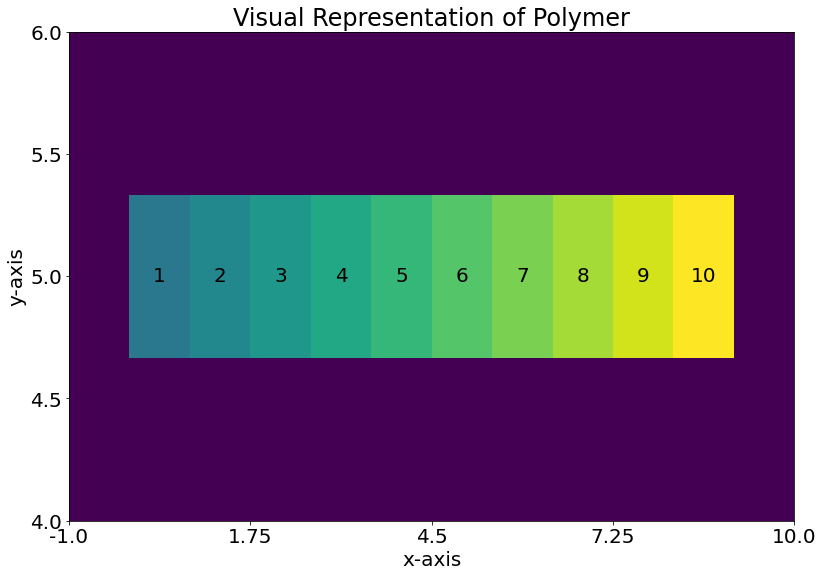

In [106]:
def illustratePolymer(polymer):
    N = len(polymer)                                            # calculate the size of the input polymer

    # find x- and y-bounds of the grid
    minx, maxx = np.min(polymer[:,0]), np.max(polymer[:,0])     
    miny, maxy = np.min(polymer[:,1]), np.max(polymer[:,1])

    grid = np.zeros((int(maxy-miny)+3, int(maxx-minx)+3))                # initialize grid
    grid -= N//2                               # set background value to -N / 2 for a better visualization of monomers with small indices

    """
    Customizing the plot
    """
    plt.figure(figsize = (13,9))
    plt.title("Visual Representation of Polymer")
    plt.xlabel(r"x-axis")
    plt.ylabel(r"y-axis")
    
    """
    Loop through all monomers of the input polymer and place their monomer number
    """
    for monomerNumber in range(N):                        
        x = int(polymer[monomerNumber, 0]-minx+1)         
        y = int(polymer[monomerNumber, 1]-miny+1)         
        grid[y, x] = monomerNumber + 1             
        plt.text(x+0.5,y+0.5,monomerNumber+1, ha = 'center', va = 'center')
    """
    Place x- and y-values on axis, and show plot
    """
    plt.xticks(ticks = np.arange(0,int(maxx-minx+3)+int(maxx-minx+3)/4,int(maxx-minx+3)/4),labels = np.arange(minx-1,maxx+1+(maxx-minx+2)/4,(maxx-minx+2)/4))
    plt.yticks(ticks = np.arange(0,int(maxy-miny+3)+int(maxy-miny+3)/4,int(maxy-miny+3)/4),labels = np.arange(miny-1,maxy+1+(maxy-miny+2)/4,(maxy-miny+2)/4))
    plt.pcolormesh(grid)
    plt.show()

""" 
Here, we visualize the horizontal polymer from task 1b) with N=10
"""
illustratePolymer(createPolymer(10))

While rotating a polymer around its monomers, one easily ends up with a polymer that does not meet the requirements as listed in task **1e)**. The following function receives a polymer and its size $N$, and checks whether it is valid or not. The function $\texttt{validPolymer}$ returns $\texttt{True}$ if the polymer is valid, and $\texttt{False}$ otherwise. To make sure that no monomers have the same coordinates, we initialize the set $\texttt{coordinateSet}$, where we add the monomer-coordinates as we loop through the monomers of the polymer. Once a monomer with already taken coordinates is encountered, $\texttt{validPolymer}$ returns $\texttt{False}$. If a monomer has unique coordinates $(x, y)$, the tuple $(x, y)$ is added to $\texttt{coordinateSet}$. To check that $m-1$ and $m+1$ are the closest neighbours of monomer $m$, we find the $x$- and $y$-distance to the monomer preceding $m$. If the sum of the $x$- and $y$-distance is not $1$, the preceding monomer cannot be one of the closest neighbours of $m$.

In [107]:
@jit
def validPolymer(polymer, N):
    """
    Check if the polymer has N monomers
    """
    if len(polymer) != N:                                      
        return False
    
    """
    Check if coordinates are unique
    """
    coordinateSet = set()                                      # initialize empty set
    coordinateSet.add((polymer[0, 0], polymer[0, 1]))          # add x- and y-coordinate of the first monomer

    for monomerNumber in range(1, N):                          # loop through the remaining monomers of the polymer

        if (polymer[monomerNumber, 0], polymer[monomerNumber, 1]) in coordinateSet: # check if the monomers coordinates are taken by a preceding monomer
            return False                                                            
        else: 
            coordinateSet.add((polymer[monomerNumber, 0], polymer[monomerNumber, 1])) # if the coordinates are unique, add them to coordinateSet

        """
        Check taxicab-distance
        """
        xDiff = np.abs(polymer[monomerNumber, 0] - polymer[monomerNumber - 1, 0])     
        yDiff = np.abs(polymer[monomerNumber, 1] - polymer[monomerNumber - 1, 1])     
        if xDiff + yDiff != 1:   
            return False          
        
    return True    

Task **1f)** states that we are to make a function that rotates the polymer, and that the input parameters are: polymer, coordinate for monomer we are rotating around, and direction of rotation. We find it faster and much simpler to find a random monomer number to rotate around, rather than a random coordinate to rotate around. If we were to follow the task syntax, our randomization code would generate monomer-number, go to coordinate, and then our function $\texttt{rotatePolymer}$ back to monomer_number, so that we can easily break the polymer into two pieces, one that is going to remain in place, and one that will be rotated. That is why we have implemented the function $\texttt{rotatePolymer}$ to not have input parameter coordinate, but rather monomer-number. We have implemented a function $\texttt{coordToMonomerNumber}$ that receives an input polymer and coordinate, and returns monomer-number. This way we could have just had input parameter coordinate in $\texttt{rotatePolymer}$ and gotten monomernumber from the function $\texttt{coordToMonomerNumber}$

Next code block implements the function described in task **1f)**. The function $\texttt{rotatePolymer}$ receives an input polymer and a monomer which the polymer will rotate around. $\texttt{rotatePolymer}$ also receives a boolean $\texttt{positiveDirection}$. $\texttt{positiveDirection=True}$ rotates the polymer in the positive direction, while $\texttt{positiveDirection=False}$ rotates the polymer in the negative direction. 

The placement of each monomer in the polymer after a rotation around a monomer $m_{rot}$, is determined by it's relative distance in $x$-direction $\Delta x$ to $m_{rot}$ and it's relative distance in $y$-direction $\Delta y$ to $m_{rot}$. We look at the monomers positions relative to $m_{rot}$ as free vectors, and since we will either be rotating them in positive or negative direction, we can simply multiply by the rotation matrix, either positive direction, or negative direction.

In positive rotation, the original vector $(1,0)$ will go to $(0,1)$ and the vector $(0,1)$ will go to $(-1,0)$. In negative rotation, the original vector $(1,0)$ will go to $(0,-1)$ and $(0,1)$ will go to $(1,0)$ in negative rotation. This is essentially all the information we need to implement rotation, since rotation is a linear operation, and these two vectors forms an orthonormal basis for $\mathbb{R}^2$.

In [152]:
"""
Here we have implemented a way to go from coordinate to monomer-number,
returns monomer number, and input parameters are polymer and the coordinate of monomer with returning monomer-number
"""


def coordToMonomerNumber(polymer, coord):
    for monomer_indices in range(len(polymer)):
        if polymer[monomer_indices].all()==np.array(coord).all():
            return monomer_indices+1

In [182]:
@jit
def rotatePolymer(polymer, monomer, positiveDirection):
    monomer -= 1                                            # subtract 1 from the monomerNumber, as the polymer-array is zero-indexed
    middleMonomer = len(polymer) // 2                       # find monomerNumber of the middle monomer in the polymer
    x, y = polymer[monomer]                                 # collect x- and y-coordinates of the monomer the polymer will rotate around
    newPolymer = np.zeros((len(polymer),2))                 # initialize a new polymer, because working inplace changed *noe*

    if middleMonomer > monomer:
        newPolymer[monomer:] = polymer[monomer:]
        newPolymer[:monomer, 0] = (2 * positiveDirection - 1) * (polymer[:monomer, 1] - y) + x
        newPolymer[:monomer, 1] = (1 - 2 * positiveDirection) * (polymer[:monomer, 0] - x) + y
        """
        Positive direction:
        delta x = delta y
        delta y = - delta x
        Negative direction:
        delta x = - delta y
        delta y = delta x

        Also uses that True is represented as 1 and False as 0.
        """
        return newPolymer
    newPolymer[:monomer+1] = polymer[:monomer+1]
    newPolymer[monomer+1:,0] = (1-2*positiveDirection)*(polymer[monomer+1:,1]-y)+x
    newPolymer[monomer+1:,1] = (2*positiveDirection-1)*(polymer[monomer+1:,0]-x)+y
    """
        Positive direction:
        delta y = delta x
        delta x = - delta y
        Negative direction:
        delta y = - delta x
        delta x = delta y
    """
    return newPolymer


Now that a polymer is able to rotate, 

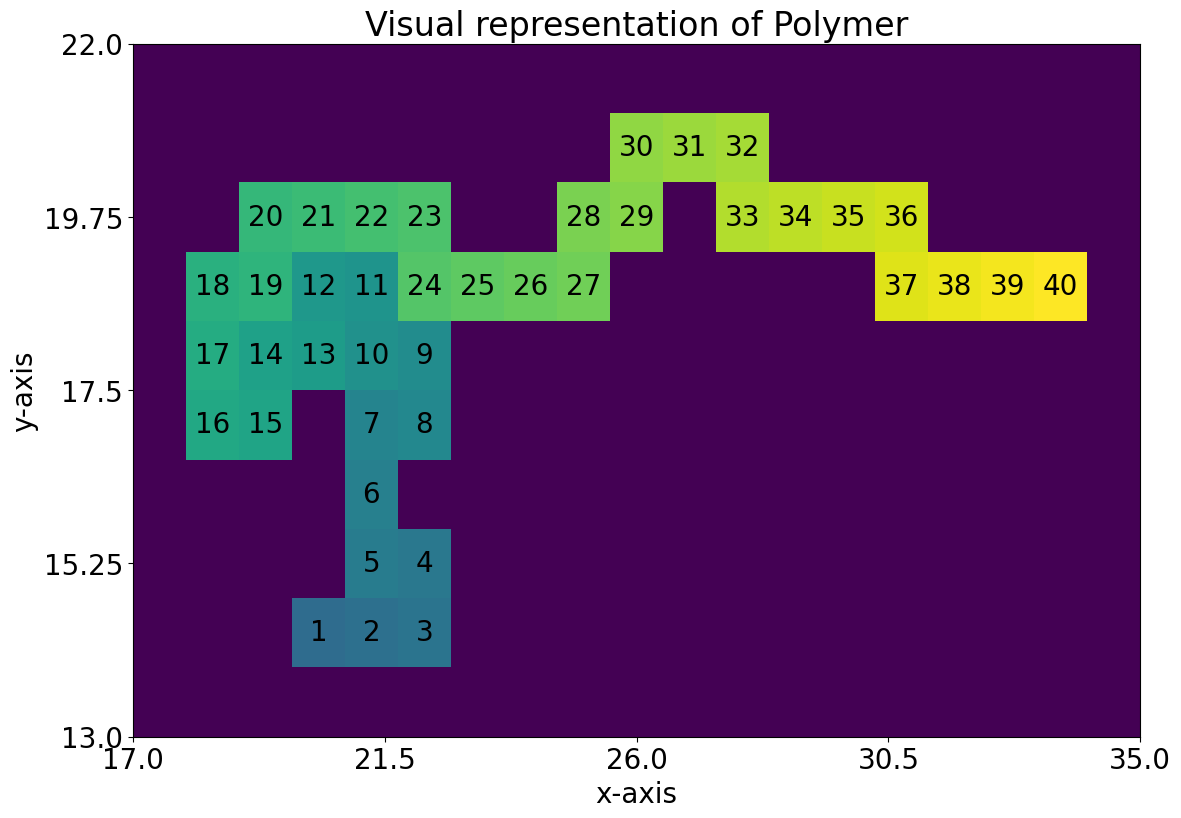

In [268]:
def rotateNTimes(N, Ns):
    rotationsMade = 0
    polymer = createPolymer(N)

    for i in range(Ns):
        monomer = np.random.randint(2, N)
        positivRetning = np.random.choice([True, False])

        twistedPolymer = rotatePolymer(polymer, monomer, positivRetning)
        if validPolymer(twistedPolymer, N):
            rotationsMade += 1
            polymer = twistedPolymer

    return polymer, rotationsMade
polymer, rot = rotateNTimes(40, 1000)
illustratePolymer(polymer)

# h)
One of the main problems within the computation time as of now is the time it takes to rotate the polymer. With the implementation we have used up to now, we split the cases so that we always only rotate the shorter side of the polymer. Thus on average, the length of the chain we rotate will be $N/2\cdot1/2 = N/4$. As we change both the x and the y value for each of these every time, we alter $N/2$ numbers on average each time. To lower this number, we reimplement the structure of the polymere. Instead of having an $N\times 2$ array which tracks the polymers coordinates, we use the fact that the polymer must be connected. 

Thus, we create our own object called Middle, which tracks the x and y coordinates of the middle and also contains two arrays. The first, called beforeMiddle, is of length number of monomers left of the middle, and it contains a singular element in each slot, namely the direction the next monomer is, relative to where one came from. 0 means straight forward, 1 means to the right and 3 means to the left. Similarly, afterMiddle does the same for the right side, just that 2 means straight forward, 1 means to the left and 3 means to the right. Finally, we have also assigned Middle with a map, just to easily keep the data together, the map maps from direction number to correct movement in the cartesian plane. 

This new implementation speeds up the rotation algorithm, as instead of changing on average N/2 datapoints, we only need to rotate one “pointer”, as then the relative distance for all points more extreme will also be moved. Furthermore, this also keeps the invaluable property that the middle always is in the center, as all pointers point from the center to the extremes. This was made possible by changing the polymer in-place, and thus avoiding copying the entire array. To change the polymer in-place was made possible by implementing an else in the rotateManyTimes. If the new polymer wasn’t legal, one would just rotate the polymer on the same monomer in the other direction. To do things like illustrate the polymer, we just start from the middle and illustrate each end by keeping track of the position we are at, which way we look and which way the pointer wants us to move. Thus, we can always construct the appropriate x and y coordinates in linear time, which is more than fast enough as all algorithms that need the x and y coordinates use linear time regardless, and results tell us that the algorithms that take linear time like for instance to check if a polymer is valid, often operate faster with the new implementation. As can be observed in the following code, this new implementation almost halves the computational time of rotateManyTimes.


In [184]:
class Middle:
    def __init__(self, x, y, N):
        self.position = np.array([x,y]) #Position of the middle
        self.beforeMiddle = np.array([0 for i in range(N//2)]) #Venstre siden av arrayet
        self.afterMiddle = np.array([2 for i in range((N-1)//2)]) # Høyre siden av arrayet
        self.map = {0:np.array([0,-1]), 1:np.array([1,0]), 2:np.array([0,1]),3:np.array([-1,0])} # Map of direction to Cartesian-coordinates change

"""
1 b) This is a new createPolymer designed around the new implementation of a polymer
"""
def createPolymerVer2(N):
    middle = Middle(N//2, N//2, N)    # Initializes the class
    return middle
"""
1 d) This is a new way to illustrate the polymer using the same principles as above but with the new implementation in mind
"""
def illustrationPolymerVer2(polymer):
    N = len(polymer.beforeMiddle) + len(polymer.afterMiddle) + 1        
    grid = np.zeros((N+1,N+1))        # Creates (N+1)*(N+1) grid
    grid -= N//2                         # Sets the backgroundvalue to -N/2 rounded down
    index = N//2
    position = np.copy(polymer.position)
    direction = 0
    for firstMonomers in range(index-1,-1,-1):
        direction = (direction + polymer.beforeMiddle[firstMonomers])%4
        position += polymer.map[direction]
        grid[position[0],position[1]] = firstMonomers + 1
    direction = 2
    position = np.copy(polymer.position)
    grid[position[0],position[1]] = index + 1
    for secondMonomers in range(0, len(polymer.afterMiddle)):
        direction = (direction + polymer.afterMiddle[secondMonomers]-2)%4
        position += polymer.map[direction]
        grid[position[0],position[1]] = secondMonomers+ index + 2
    plt.pcolormesh(grid)
    plt.show()

"""
1 e) Checks if the polymer is intact and legal
"""

def validPolymerVer2(polymer, N):
    if len(polymer.beforeMiddle) + len(polymer.afterMiddle) + 1 != N: #Is the polymer of correct length
        return False
    coordinateSet = set()
    coordinateSet.add((polymer.position[0], polymer.position[1]))
    index = N//2
    position = np.copy(polymer.position)
    direction = 0
    #Test before middle array
    for firstMonomers in range(index-1,-1,-1):
        if polymer.beforeMiddle[firstMonomers] not in polymer.map: #Check if the direction stored is valid (between 0 and 3 inclusive), thus that they are consecutive
            return False
        direction = (direction + polymer.beforeMiddle[firstMonomers])%4
        position += polymer.map[direction]
        if (position[0],position[1]) in coordinateSet: #Checks if there exists an overlap of coordinates
            return False
        else:
            coordinateSet.add((position[0],position[1]))
    direction = 2
    position = np.copy(polymer.position)
    #Test after middle array, note that an overlap between before and after arrays will still be discovered
    for secondMonomers in range(0,len(polymer.afterMiddle)):
        if polymer.afterMiddle[secondMonomers] not in polymer.map: #Check if the direction stored is valid (between 0 and 3 inclusive), thus that they are consecutive
            return False
        direction = (direction + polymer.afterMiddle[secondMonomers]-2)%4
        position += polymer.map[direction]
        if (position[0],position[1]) in coordinateSet: #Checks if there exists an overlap of coordinates
            return False
        else:
            coordinateSet.add((position[0],position[1]))
    return True

"""
1 f) Implementation of rotation, as previously, the middle rounded upwards is kept at a constant position
"""
def rotationGoBrrrrVer2(polymer, monomer, positivRetning):
    """
    Note that neither the first nor the last monomer in the polymer is represented in the array, and that also we call the monomers by 1-indexing
    Thus we need to subtract two to both account for the first monomer not being in the array, and also for that we go from 1-indexing to 0-indexing
    """
    monomer -= 2
    middleMonomer = len(polymer.beforeMiddle)-1 #Finds the middle rounded up 
    if middleMonomer > monomer: #Checks if we are before the middle
        polymer.beforeMiddle[monomer] = (polymer.beforeMiddle[monomer] + 2*positivRetning-1) % 4
        """
        Positive direction:
        direction = direction + 1
        Negative Direction:
        direction = direction - 1
        
        Then readjust so that for instance right from pointing downwards is left, not an undefined value

        Follows from that the direction number increases in the negative direction
        """
        return polymer
    polymer.afterMiddle[monomer-middleMonomer] = (polymer.afterMiddle[monomer-middleMonomer] - 2*positivRetning+1) % 4
    """
    Positive direction:
    direction = direction - 1
    Negative Direction:
    direction = direction + 1

    Then readjust so that for instance right from pointing downwards is left, not an undefined value

    Follows from that the direction number increases in the negative direction
    """
    return polymer

"""
1 g) This is the reimplementation of the similar algorithm above, with the key difference being what happens when a rotation doesn't work.
Here we undo the rotation by giving the same polymer and monomer, just the opposite rotation direction. This is necessary as we edit the polymer
in place, and thus can't just discard the changes. 
"""
def rotateNTimesVer2(N, Ns):
    rotationsMade = 0
    polymer = createPolymerVer2(N)

    for i in range(Ns):
        monomer = np.random.randint(2, N)
        positivRetning = np.random.randint(0,2)
        
        polymer = rotationGoBrrrrVer2(polymer, monomer, positivRetning)
        if validPolymerVer2(polymer, N):
            rotationsMade += 1
        else:
            polymer = rotationGoBrrrrVer2(polymer,monomer,(positivRetning+1)%2)

    return polymer, rotationsMade

"""
Here is a comparrison of the old rotateManyTimes and rotateManyTimesVer2
"""
%timeit rotateNTimes(150, 10000)
%timeit rotateNTimesVer2(150,10000)

"""
Note, that here, rotateNTimes uses jit while rotateNTimesVer2 doesn't, thats why rotateNTimesVer2 is much slower than rotateNTimes. 
Without jit, rotateNTimesVer2 is approximetly twice as fast as rotateNTimes (tested previously but not in this code). If we managed to get jit to 
work for rotateNTimesVer2, it probably would be faster by a similar factor of two, but it is more difficult as Ver2 uses an own defined object, 
making it more difficult. However, because we have gotten it to work for the old implementation, and that the old implementation is much more 
clear and sufficiently quick, we have chosen to abandon the second implementation, and continue focusing on the old implementation. 
"""

112 ms ± 982 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
787 ms ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


"\nNote, that here, rotateNTimes uses jit while rotateNTimesVer2 doesn't, thats why rotateNTimesVer2 is much slower than rotateNTimes. \nWithout jit, rotateNTimesVer2 is approximetly twice as fast as rotateNTimes (tested previously but not in this code). If we managed to get jit to \nwork for rotateNTimesVer2, it probably would be faster by a similar factor of two, but it is more difficult as Ver2 uses an own defined object, \nmaking it more difficult. However, because we have gotten it to work for the old implementation, and that the old implementation is much more \nclear and sufficiently quick, we have chosen to abandon the second implementation, and continue focusing on the old implementation. \n"

The function $\texttt{rotateNTimes}$ receives the argument $\texttt{Ns}$, which is the number of rotations we wish to complete. However, since we encounter several non-valid polymers while rotating many times, we want to see how many of those $\texttt{Ns}$ rotations actually resulted in valid polymers. $\texttt{rotateNTimes}$ returns $\texttt{rotationsMade}$, which tells us how many rotations resulted in a valid polymer. The following function, as described in **1i)**, plots the percentage of valid rotations as a function of the size $N$ of the polymer. $\texttt{plotValidPercentage}$ receives $\texttt{minSize}$ and $\texttt{maxSize}$, which are the minimum and maximum sizes of the polymers we are to rotate. $\texttt{minSize}$ and $\texttt{maxSize}$ are by default set to $10$ and $500$, respectively. $\texttt{plotValidPercentage}$ also has the input $\texttt{NsArray}$, which is an array of the different $\texttt{Ns}$ we want to test. $\texttt{NsArray}$ is default set to $1000$ rotations.

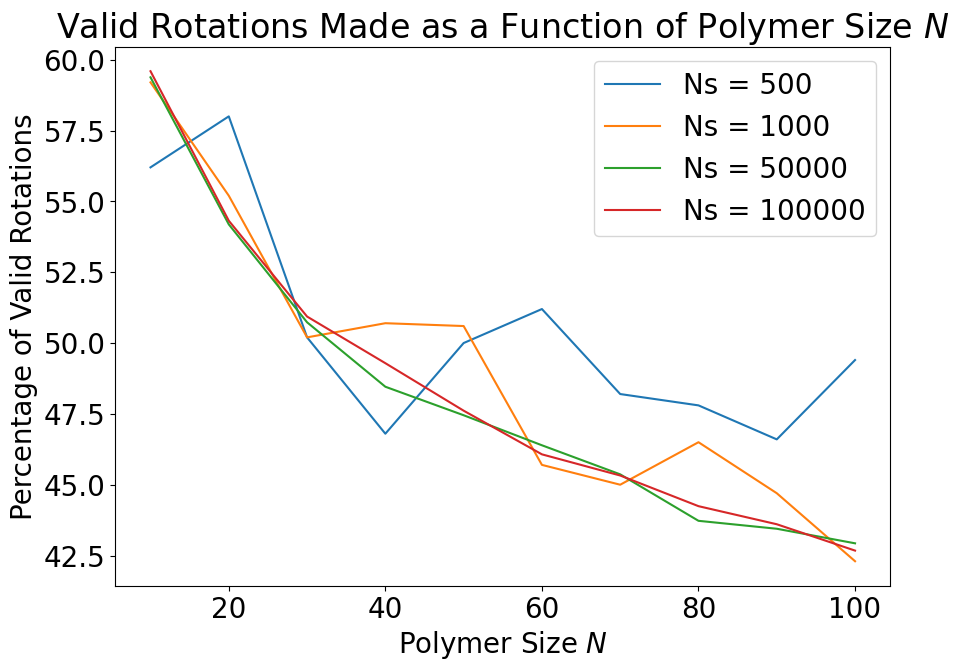

In [185]:
def plotValidPercentage(minSize = 10, maxSize = 500, NsArray = np.array([1000])):
    """
    Initializing the sizes of the polumers to simulate through rotateNTimes and ensuring they are of type int to avoid type-errors later
    """
    sizes = np.arange(minSize, maxSize + 1, 10)     
    intSizes = sizes.astype(int)                    
    """
    Initialising the plot
    """
    plt.figure(figsize = (10, 7))
    """
    Simulating the rotations and plotting the percentage of valid rotations
    """
    for Ns in NsArray:
        validRotations = np.array([rotateNTimes(N, Ns)[1] for N in intSizes])
        plt.plot(intSizes, (validRotations / Ns) * 100, label = f'Ns = {Ns}')    
    """
    Customizing the plot
    """
    plt.xlabel(r'Polymer Size $N$')
    plt.ylabel('Percentage of Valid Rotations')
    plt.title('Valid Rotations Made as a Function of Polymer Size $N$') 
    plt.legend()
    plt.show()

plotValidPercentage(10, 100, np.array([500, 1000, 50000, 100000]))

*Diskusjon av Ns*
With $\texttt{Ns=1000}$ for polymers of size between $\texttt{minSize=10}$ and $\texttt{maxSize=500}$, the plot above shows that we achieve more valid rotations for smaller $N$. However, at around $N=100$ the percentage of valid rotations stabilizes between $40\%$ and $47.5\%$. By increasing $\texttt{Ns}$, we get the following result.

As described in task **1j)**, we now implement energy calculations. The following function $\texttt{calculateEnergy}$ receives a polymer and a matrix $V$. The matrix $V$ is, as described in the project description, a symmetric matrix that contains the strengths of the interactions between monomers.

*Mer om V*

To calculate the energy of each polymer, there are three major ideas behind our design of the energyalgorithm. Firstly, we have realised that if monomers $x$ and $y$ are neighbours, with $y>x$ and $x,y\in\mathbb{Z}^+$, we only need to catch that $y$ is neighbour to $x$. This is because the potential is symmetrical, and thus instead of adding half of the potential for each of them, we just add the entire potential when we discover that $y$ is a neighbour to $x$. Secondly, we discovered that it doesn't matter that we discover that $m$ is a neighbour with $m-1$, as adding the potential between them will just be adding 0. Thirdly, we discovered that it doesnt matter if we store all potential neighbours to a coordinate as a list and loop over them, as a point can maximum have 4 neighbours, and thus one only needs to loop over 4 values regardless. Thus, our design method of the algorithm is that we start at the beginning of the polymer, and for each monomer, we log which coordinates the monomer is neighbour to, and save these data in a dictionary where the key is a coordinate, and the values are the monomers discovered so far that are neighbours to this coordinate. As dictionaries are hash-tables in python, each coordinate has finite neighbours and each monomer has finite coordinate-neighbours, each iteration over a monomer should take constant time, and calculateEnergy should average $\theta(n)$, which seems reasonable to be as efficient in asymptotic notation as this algorithm can be.

In [186]:
def calculateEnergy(polymer, V):
    """
    Calculate the energy of the polymers
    Input:
    polymer: The polymer to calculate the energy for
    V: The potential used to calculate the energy
    """
    energy = 0
    neighbourDict = {}
    direction = [[0, 1], [0, -1], [1, 0], [-1, 0]]
    """ 
    Loop over the monomers in the polymers, and checking if they are neighbours
    """
    for monomerNumber, coordinates in enumerate(polymer):
        cordTuple = (coordinates[0], coordinates[1])            
        """
        Checking if the coordinates of the monomer makes it neighbour with any previously checked monomers.
        """
        if cordTuple in neighbourDict:                          # 
            for n in neighbourDict[cordTuple]:
                energy += V[monomerNumber][n]
        """
        Adding the neighbouring spaces of the monomer to the neighbourdictionary, in case one of the later monomers are on one of these spots
        """
        for vec in direction:
            temp = (coordinates[0] + vec[0], coordinates[1] + vec[1])

            if temp in neighbourDict:
                neighbourDict[temp].append(monomerNumber)
            else:
                neighbourDict[temp] = [monomerNumber]
    """
    Returning the energy
    """
    return energy

We want to use this function to calculate the energy of the two polymers from task **1g)**. As task **1j)** asks, we use a $V$-matrix where all non-zero elements are $-1$. First, we define the function $\texttt{makePotential}$, to make the matrix $V$.

In [187]:
def makePotential(N, backgroundValue):
    """
    Make a potential matrix:
    Input:
    N: The size of the polymer, and thus the length of each side of the potential matrix
    backgroundValue: The value of all cells not supposed to be 0 (the cells representing the interaction of monomer m with monomers m-1,m,m+1)
    """
    V = np.zeros((N, N)) + backgroundValue
    """
    Setting the correct cells to 0
    """
    for m in range(N):
        V[m, m] = 0
        if m > 0:
            V[m, m - 1] = 0
            V[m - 1, m] = 0

    return V

# N = 15
# V = makeDiagonalForceArray(N, -4*10**(-21))
# pol, rot = rotateManyTimes(N,1000)
# illustrationPolymer(pol)
# print(calculateEnergy(pol, V))

*Diskusjon om forskjell i energi*

Now that we have a function that can calculate the energy of a given polymer, we can start to simulate a polymer through a Monte-Carlo simulation. To achieve this, rotate the polymer, and check if it is valid. If it is, it counts as a successful rotation, and we know check if the polymer wants this new orientation by considering the energy of the new polymer to the old algorithm as explained in Algorithm 2.

First, we implement the function $\texttt{calculateDiameter}$, which finds the longest cartesian distance between two points on the polymer. Thus, for instance, a polymer thats of dimensions $1\times N$ will get a diameter of $\sqrt{N^2+1}$ as the longest distance would be opposing corners. $\texttt{calculateDiameter}$ has only one argument, which is a polymer. Our algorithm checks the distance between all pair of monomers and returns the largest distance. This is not a time efficient algorithm, we therefore use $\texttt{@jit}$ to reduce the runtime.

In [188]:
@jit
def calculateDiameter(polymer):
    """
    Calculate the diameter of the polymer:
    Input:
    polymer: The polymer to calculate the diameter of
    """
    maxDist = 0

    """
    Find the distance between each pair and return the maximum one.
    As the square root function is bijective, finding the maximum without it is the same as finding the maximum with applying it, so to save
    computation time, we only take the square root of the answer
    """
    for i in range(len(polymer)):
        for j in range(i + 1, len(polymer)):
            distance = np.sum((polymer[i] - polymer[j]) ** 2)

            if distance > maxDist:
                maxDist = distance

    return np.sqrt(maxDist)

As instructed in task **2a)**, we now implement algorithm 2. $\texttt{metropolisAlgorithm}$ takes in a $\texttt{polymer}$, the potential matrix $\texttt{V}$, the number of rotations $\texttt{Ns}$ and the temperature $\texttt{T}$. To answer task **2g)** we also added the boolean argument $\texttt{includeDiameter}$, which is default set to $\texttt{False}$, so we don't have to calculate the diameter each time we use the $\texttt{metropolisAlgorithm}$.

In [189]:
k_b = 1.38 * 10 ** (-23)            # Boltzmanns constant

def metropolisAlgorithm(polymer, V, Ns, T, includeDiameter = False):
    """
    Implementation of algorithm 2 with diameter calculations:
    Input:
    polymer: The polymer to simulate
    V: The potential matrix to calculate the energy of the polymer
    Ns: The number of successfull rotations needed
    T: The temperature at which the simulation takes place
    includeDiameter: Whether the metropolisAlgorithm should calculate the diameters or not
    """
    E_array = np.zeros(Ns)
    E = calculateEnergy(polymer, V) # Calculate the initial energy of the polymer

    if includeDiameter:
        d_array = np.zeros(Ns)
        d = calculateDiameter(polymer) # If relevant, calculate the intital diameter of the polymer
        d_array[0] = d

    """
    Setting constants to help further down in the process
    """
    rotationsMade = 0
    N = len(polymer)    
    beta = 1 / (k_b * T)
    E_array[0] = E

    """
    The main body of the algorithm, continue until Ns sucessfull rotations achieved
    """
    while rotationsMade < Ns - 1:
        newpolymer = rotatePolymer(polymer, np.random.randint(2, N), np.random.randint(0,2)) #Simulate a rotation

        if validPolymer(newpolymer,N):
            """
            Valid rotation achieved, check if the polymer should change
            """
            rotationsMade += 1
            E_new = calculateEnergy(newpolymer, V)

            if includeDiameter:
                d_new = calculateDiameter(newpolymer)

            if E_new < E:
                """
                Update the polymer if the new polymer has less energy
                """
                polymer = newpolymer
                E = E_new

                if includeDiameter:
                    d = d_new

            elif np.random.uniform() < np.exp(-beta * (E_new - E)):
                """
                Update the polymer if the new polymer has more energy, but probability dictates that we should update regardless
                """
                polymer = newpolymer
                E = E_new

                if includeDiameter:
                    d = d_new
            """
            Insert the newest value of the energy (and possible the diameter) into the respective arrays
            """
            E_array[rotationsMade] = E
            if includeDiameter:
                d_array[rotationsMade] = d

    """
    Return the data
    """
    if includeDiameter:
        return polymer, E_array, d_array

    return polymer, E_array

We want to see how the polymers energy varies as a function of the number of Monte Carlo-steps. The following function plots said energy for a low temperature $T=50K$ and a higher temperature $T=373K$. To continue working with these certain polymers, $\texttt{plotEnergy}$ returns the polymers simulated.

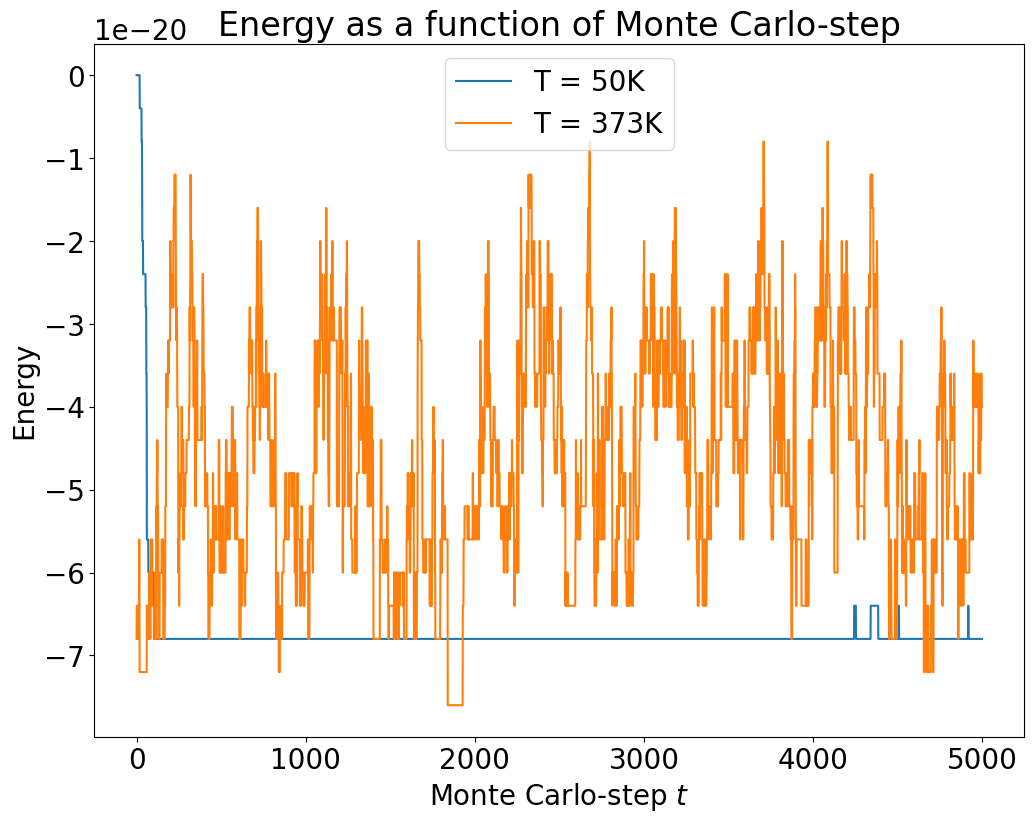

In [336]:
def plotEnergy(polymer, V, Ns, T_array):
    """
    Input:
    polymer: The polymer to simulate the metropolisAlgorithm on with various temperatures
    V: The potential matrix for the metropolisAlgorithm
    NS: The number of successfull rotations for the metropolisAlgorithm
    T_array: The temperatures to simulate the metropolisAlgorithm on
    """
    polymers = []
    plt.figure(figsize = (12, 9))
    """
    Plotting the energy-arrays for each temperature
    """
    for T in T_array:
        polymer, E_array = metropolisAlgorithm(polymer, V, Ns, T)
        polymers.append(polymer)
        plt.plot(E_array, label = f'T = {T}K')
    """
    Customizing the plot
    """
    plt.xlabel(r'Monte Carlo-step $t$')
    plt.ylabel('Energy')
    plt.title('Energy as a function of Monte Carlo-step')
    plt.legend()
    plt.show()
    """
    Returnin the achieved polymers for a later problem
    """
    return polymers

N = 30
V = makePotential(30, -4 * 10 ** (-21))
polymer = plotEnergy(createPolymer(N), V, 5000, [50, 373])

The plot shows that the energy for the polymer at a lower temperature $T=50K$ varies less than the energy of the polymer at the higher temperature $T=373K$. The polymer at $T=50K$ has a quick drop in the energy after a couple Monte Carlo-steps, before it stabilizes at a local energy minimum. In some simulations, the polymers manages to break out of the local energy minimum and the energy drops further to another local energy minimum.

The polymer at $T=373K$, on the other hand, has a similar drop in energy in the very beginning, before it oscillates. The polymer at a higher temperature reaches lower energies throughout the simulation. However, the polymer at lower temperatures has a lower energy average, as it stabilizes at a low energy instead of oscillating between lower and higher energies.

The following code block illustrates how these two polymers look after the simulation, as mentioned in task **2c)**.

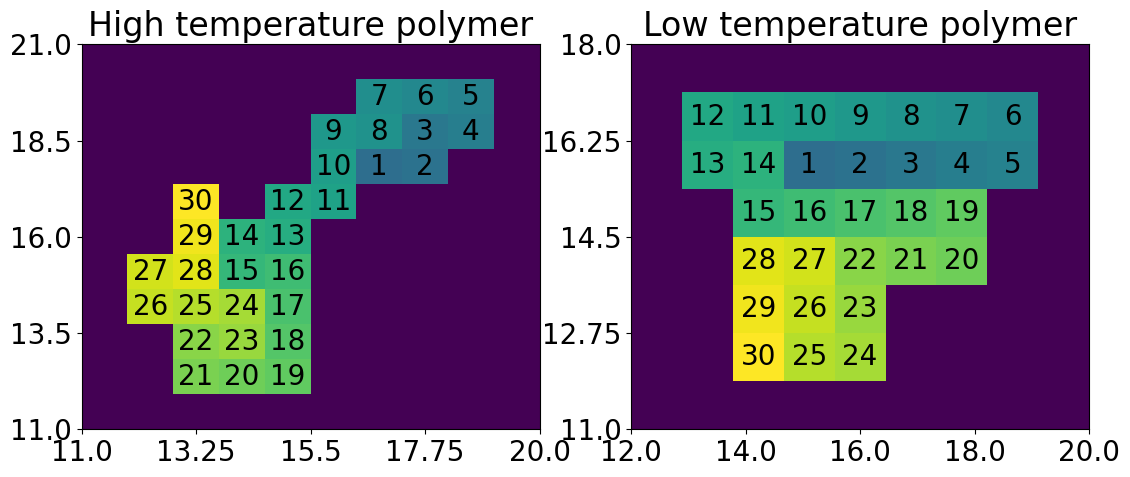

In [324]:
def illustrationOfOnePolymer(polymer):
    """
    Input:
    polymer: The polymer to create a grid for
    """
    N = len(polymer)                               # calculate the size of the input polymer
    """
    Getting the dimensions of the needed grid by finding the min and max value for both the x and y axis. 
    """
    minx, maxx = np.min(polymer[:,0]), np.max(polymer[:,0])
    miny, maxy = np.min(polymer[:,1]), np.max(polymer[:,1])
    """
    Creating the grid and placing the monomers in the middle, with the non-occupied spaces having a value of N/2 rounded down and the monomers
    having the value of their monomerNumber (1,...,N)
    """
    grid = np.zeros((int(maxy-miny)+3, int(maxx-minx)+3))               
    grid -= N//2     
    for monomerNumber in range(N):                 # loop through all monomers of the input polymer
        x = int(polymer[monomerNumber, 0]-minx+1)         # collect x-coordinate of the monomer relative to the grid
        y = int(polymer[monomerNumber, 1]-miny+1)         # collect y-coordinate of the monomer relative to the grid
        grid[y, x] = monomerNumber + 1    
    return grid,minx,maxx,miny,maxy



def multiplePlotsPolymers(polymer1,polymer2, title1,title2):
    """
    Input:
    polymer1, polymer2: The two polymers to be illustrated
    title1, title2: The title over the respective plots of the polymers
    """
    fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13,5)) #Initialising two plots next to each other

    #Sublot 1
    """
    Getting the correct grid and plotting the data in a pcolormesh for the first polymer
    """
    N = len(polymer1)
    grid_1,minx,maxx,miny,maxy = illustrationOfOnePolymer(polymer1)
    ax1.pcolormesh(grid_1)
    ax1.set(title = title1)
    """
    Placing the monomer-numbers over the monomers in the plot for the first polymer.
    """
    for monomerNumber in range(N):
        x = int(polymer1[monomerNumber, 0]-minx+1)         
        y = int(polymer1[monomerNumber, 1]-miny+1)                
        ax1.text(x+0.5,y+0.5,monomerNumber+1, ha = 'center', va = 'center')
    """
    Customising the axis for the first polymer, so that the correct x and y coordinates are illustrated
    """
    ax1.set_xticks(ticks = np.arange(0,int(maxx-minx+3)+int(maxx-minx+3)/4,int(maxx-minx+3)/4),labels = np.arange(minx-1,maxx+1+(maxx-minx+2)/4,(maxx-minx+2)/4))
    ax1.set_yticks(ticks = np.arange(0,int(maxy-miny+3)+int(maxy-miny+3)/4,int(maxy-miny+3)/4),labels = np.arange(miny-1,maxy+1+(maxy-miny+2)/4,(maxy-miny+2)/4))
    
    #Subplot 2
    """
    Getting the correct grid and plotting the data in a pcolormesh for the first polymer
    """
    N = len(polymer2)
    grid_2,minx,maxx,miny,maxy = illustrationOfOnePolymer(polymer2)
    ax2.pcolormesh(grid_2)
    ax2.set(title = title2)
    """
    Placing the monomer-numbers over the monomers in the plot for the second polymer.
    """
    for monomerNumber in range(N):
        x = int(polymer2[monomerNumber, 0]-minx+1)         
        y = int(polymer2[monomerNumber, 1]-miny+1)                  
        ax2.text(x+0.5,y+0.5,monomerNumber+1, ha = 'center', va = 'center')
    """
    Customising the axis for the second polymer, so the correct x and y coordinates are illustrated
    """
    ax2.set_xticks(ticks = np.arange(0,int(maxx-minx+3)+int(maxx-minx+3)/4,int(maxx-minx+3)/4),labels = np.arange(minx-1,maxx+1+(maxx-minx+2)/4,(maxx-minx+2)/4))
    ax2.set_yticks(ticks = np.arange(0,int(maxy-miny+3)+int(maxy-miny+3)/4,int(maxy-miny+3)/4),labels = np.arange(miny-1,maxy+1+(maxy-miny+2)/4,(maxy-miny+2)/4))
    """
    Plot the two colormeshes
    """
    plt.show()

# V=makeDiagonalForceArray(30,-4*10**(-21))
# polymer_high_temp, E_array_high_temp=metropolisAlgorithm(createPolymer(30),V,5000,350)
# polymer_low_temp, E_array_low_temp=metropolisAlgorithm(createPolymer(30),V,5000,75)
# multiplePlotsPolymers(polymer_high_temp, polymer_low_temp, "High temperature polymer", "Low temperature polymer")

# illustrationPolymer(polymer)
# print(E_array[-1])

Until now, we've looked at potential matrices $V$ where all non-zero values are the same. As instructed in task **2d)**, the following function $\texttt{makeSymmetricPotential}$ 

In [192]:
def makeSymmetricPotential(N, generalValue, scaling, tuplesToScale):
    """
    Input:
    N: The length of the polymer
    generalValue: the value of the cells which are neither 0 nor the interactions which are to be scaled
    scaling: the factor which the generalValue is multiplied with for the specified pairs
    tuplesToScale: the pairs which are to have a difference potential between them than the general value
    """

    potential = np.zeros((N,N)) + generalValue # Set the backround value
    """
    Ensure that the the potential between consecutive monomers and the monomers with themselves is 0
    """
    for i in range(N):
        potential[i,i] = 0
        if i > 0:
            potential[i-1,i] = 0
            potential[i,i-1] = 0
    """
    Scaling the tuples to scale, and ensuring that the matrix stays symmetric
    """
    for tup in tuplesToScale:
        potential[tup] = generalValue*scaling
        potential[tup[1],tup[0]] = generalValue*scaling
    return potential # returning the potential
# N = 15
# V = createFunkyPotential(N,-4*10**(-21), 100, [(0,N-1),(1,N-2),(2,N-3),(3,N-4),(4,N-5),(N-1,N-4)])
# pol, array = metropolisalgoritmen(createPolymer(N), V, 100, 50)
# print(calculateEnergy(pol,V))
# print(min(array))
# illustrationPolymer(pol)


# 2e)

In [330]:
def computeAverageEnergyAndSTD(V, T, Ns=1500, N=30):                            # Ns must be over 1000
    """
    Initialize and simulate the metropolisAlgorithm for a polymer of length N
    """
    polymer = createPolymer(N)
    _, energy = metropolisAlgorithm(polymer, V, Ns, T)
    """
    Restricting the energy-data contributing to the expected value and standard deviation to the values after a 1000, to give the polymer time
    to stabilize
    """
    importantEnergy = energy[1000:]                                            
    return np.average(importantEnergy), np.std(importantEnergy, ddof=1)

def plotExpectedAndSTDEnergy(V,lowTemp, highTemp, TempStep, Ns=1500, N=30):     # Ns must be over 1000
    TempArray = np.arange(lowTemp,highTemp,TempStep)
    """
    Get the expectedvalue and experimental standard deviation for energy as a function of temperature
    """
    expectedValue, standardDeviation = np.zeros(len(TempArray)), np.zeros(len(TempArray))
    for temp_index in range(len(TempArray)):
        expectedValue[temp_index], standardDeviation[temp_index] = computeAverageEnergyAndSTD(V, TempArray[temp_index], Ns, N)
    """
    Plot the information
    """
    plt.errorbar(TempArray, expectedValue, yerr = standardDeviation)
    plt.show()

# plotExpectedAndSTDEnergy(V, lowTemp=10,highTemp=1000,TempStep=30)

# 2f)

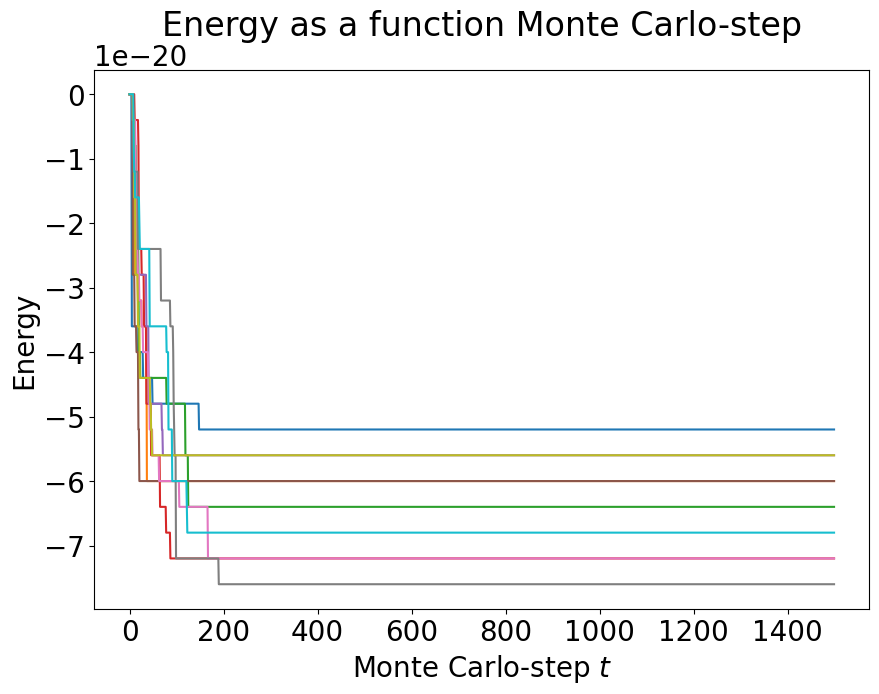

In [329]:
def plotEnergyLowTemp(V, T, Ns = 1500, N = 30):
    plt.figure(figsize = (10, 7))
    
    """
    Simulate the metropolisAlgorithm 10 times and plotting the energy for each
    """
    for sim in range(10):
        polymer = createPolymer(N)
        _, energy = metropolisAlgorithm(polymer, V, Ns, T)
        plt.plot(energy)

    """
    Fixing the layout of the figure:
    """
    plt.xlabel(r'Monte Carlo-step $t$')
    plt.ylabel('Energy')
    plt.title('Energy as a function Monte Carlo-step')
    plt.show()

plotEnergyLowTemp(V, 20)

# 2g)

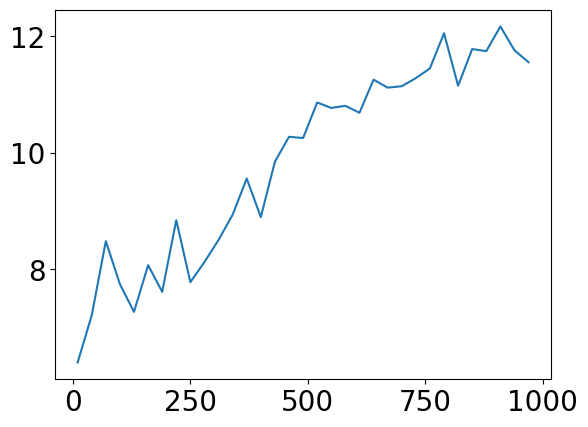

In [202]:
def computeAverageDiameterAndSTD(V, T, Ns=1500, N=30):                              # Ns must be over 1000
    polymer = createPolymer(N)                                                      # Create a polymer to simulate
    _,_,diameter = metropolisAlgorithm(polymer, V, Ns, T, includeDiamter=True)      # Get the diameter-array
    importantDiameter = diameter[1000:]                                             # Remove the first 1000, so it stabilizes
    return np.average(importantDiameter)                                            # Return the average and the experiemental standarddeviation

def getExpectedAndSTDDiameterArray(lowTemp, highTemp, TempStep, Ns=1500, N=30):     # Ns must be over 1000
    """
    Create a random symmetric matrix with values between -6*10**(-21) and -2*10**(-21)
    """
    V = np.zeros((N,N))
    for i in range(N):
        for j in range(i-1):                                                        # To ensure that the diagonal and the lines directly above and below are 0
          V[i,j]=(np.random.uniform(-6,-2))*10**(-21)                               

    V=V+V.transpose()                                                               # Make it symmetric

    """
    Calculate the exepcted value and standard deviation a range of tempeartures
    """
    tempArray = np.arange(lowTemp,highTemp,TempStep)                                # Create a temperature array which contains the temperatures we are gonna measure
    expectedValue = np.zeros(len(tempArray))
    for index in range(len(tempArray)):
        expectedValue[index] = computeAverageDiameterAndSTD(V, tempArray[index], Ns, N)
    return tempArray, expectedValue
    
def plotExpectedAndSTDDiameter(lowTemp, highTemp, tempStep, Ns=1500, N=30):
    tempArray, expectedValue = getExpectedAndSTDDiameterArray(lowTemp,highTemp, tempStep, Ns, N)
    """
    Plot the expected value and standardDeviation
    """
    plt.plot(tempArray, expectedValue)
    plt.show()

plotExpectedAndSTDDiameter(lowTemp=10, highTemp=1000, tempStep=30, Ns=3000, N=30)

# %timeit plotExpectedAndSTDDiameter(lowTemp=10, highTemp=1000, TempStep=30, Ns=3000, N=30)

# 2h)

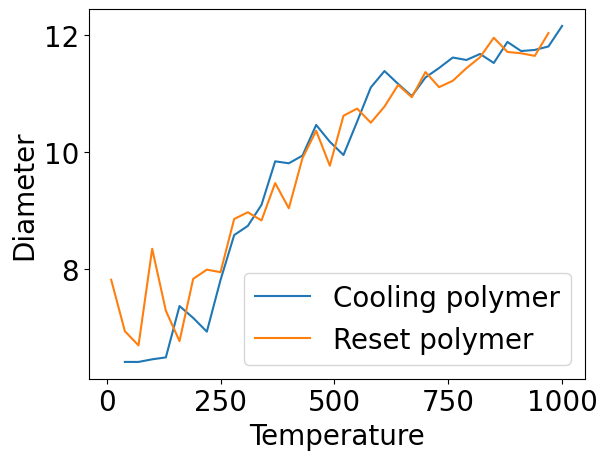

In [201]:
def computeAverageDiameterAndSTDDownwardsVersion(polymer, V, T, Ns=1500):
    """
    Takes in a polymer implemented as a N*2 array as usual, a N*N potential matrix, a temperature T to simulate the Metropolis algorithm,
    and Ns, which is the number of rotations to accomplish. 
    """

    polymer,_,diameter = metropolisAlgorithm(polymer, V, Ns, T, includeDiamter=True) 
    importantDiameter = diameter[1000:] # Note Ns > 10000

    """
    Returns the polymer and the average diameter of the polymer after the simulation has stabilised (After 1000 accomplished rotations)
    """
    return polymer, np.average(importantDiameter)

def getExpectedAndSTDDiameterDownwardsVersionArray(lowTemp, highTemp, tempStep, Ns, N): # Similar to previously, just with reusing of polymer
    
    polymer = createPolymer(N)  #Creating the polymer

    """
    Creating a random symmetrical matrix with values between -6*10**(-21) and -2*10**(-21)
    """
    V = np.zeros((N,N))
    for i in range(N):
        for j in range(i-1):
          V[i,j]=(np.random.uniform(-6,-2))*10**(-21)

    V=V+V.transpose()

    
    tempArray = np.arange(highTemp,lowTemp,-tempStep) #Creating a temperature array

    """
    Finding the expected diameter of the polymer at the given tempeartures
    """
    expectedValue = np.zeros(len(tempArray))
    for index in range(len(tempArray)):
        polymer, expectedValue[index]= computeAverageDiameterAndSTDDownwardsVersion(polymer, V, tempArray[index], Ns)

    
    return tempArray, expectedValue

def plotComparisonDownwardsAndReset(lowTemp, highTemp, tempStep, Ns = 1500, N = 30):
    """
    Plot the expected diameter as a function of temperature where one simulates a cooling process, and thus start at a high temperature and reuse
    the old polymer for the new simulation
    """
    tempArray, expectedValue = getExpectedAndSTDDiameterDownwardsVersionArray(lowTemp, highTemp, tempStep, Ns, N)
    plt.plot(tempArray, expectedValue, label = "Cooling polymer")

    """
    Plot of the expected diameter as a function of temperature where the polymer is reset to the default position for each simulation
    """
    tempArrayReset, expectedValueReset = getExpectedAndSTDDiameterArray(lowTemp, highTemp, tempStep, Ns, N)
    plt.plot(tempArrayReset, expectedValueReset, label = "Reset polymer")

    """
    Fixing the appearance of the plot
    """
    plt.legend()
    plt.xlabel("Temperature")
    plt.ylabel("Diameter")
    plt.show()

plotComparisonDownwardsAndReset(lowTemp=10, highTemp=1000, tempStep=30, Ns=3000, N=30)
#%timeit plotExpectedAndSTDDiameterDownwardsVersion(lowTemp=10, highTemp=1000, tempStep=30, Ns=3000, N=30)